##### Copyright 2020 The TensorFlow Quantum Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This notebook shows an example of how to optimize variational parameters for QAOA using TFQ

First we must install the required libraries

In [0]:
!pip install --upgrade cirq==0.7.0

In [0]:
!pip install --upgrade tensorflow==2.1.0

In [0]:
!pip install tfq-nightly

Next, we import necessary modules

In [0]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
#supress warning for matplotlib
import warnings
warnings.filterwarnings("ignore")

In [0]:
import networkx as nx

We can use QAOA to solve Max-cut. First we need to generate a 3-regular graph with 10 nodes upon which to find the Max-cut using QAOA

In [0]:
# generate a 3-regular graph with 10 nodes
maxcut_graph = nx.random_regular_graph(n=10,d=3)

Let's visualize the graph

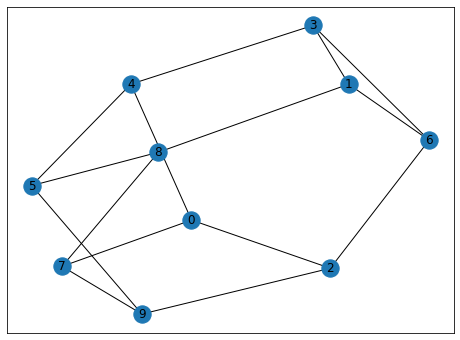

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
nx.draw_networkx(maxcut_graph, ax=ax)

In [0]:
cirq_qubits = cirq.GridQubit.rect(1, 10)

In [0]:
# create layer of hadamards to initialize the superposition state of all 
# computational states
hadamard_circuit = cirq.Circuit()
for node in maxcut_graph.nodes():
    qubit = cirq_qubits[node]
    hadamard_circuit.append(cirq.H.on(qubit))

In [0]:
# define the two parameters for one block of QAOA
qaoa_parameters = sympy.symbols('a b')

In [0]:
# define the the mixing and the cost Hamiltonian, H_M and H_P
mixing_ham = 0
for node in maxcut_graph.nodes():
    qubit = cirq_qubits[node]
    mixing_ham += cirq.PauliString(cirq.X(qubit))

cost_ham = maxcut_graph.number_of_edges()/2
for edge in maxcut_graph.edges():
    qubit1 = cirq_qubits[edge[0]]
    qubit2 = cirq_qubits[edge[1]]
    cost_ham += cirq.PauliString(1/2*(cirq.Z(qubit1)*cirq.Z(qubit2)))

# generate the qaoa circuit
qaoa_circuit = tfq.util.exponential(operators = [cost_ham, mixing_ham], 
                                    coefficients = qaoa_parameters)

Subsequently, we use these ingredients to build our model. We note here in this case that QAOA has no input data and labels, as we have mapped our graph to the QAOA circuit. To use the TFQ framework we specify the Hadamard circuit as input and convert it to a TFQ tensor. We may then construct a tf.keras model using our QAOA circuit and cost in a TFQ PQC layer, and use a single instance sample for training the variational parameters of the QAOA with the Hadamard gates as an input layer and a target value of $0$ for our loss function. This translates into the following code:

In [0]:
# define the model and training data
model_circuit, model_readout = qaoa_circuit, cost_ham
input_ = [hadamard_circuit]
input_ = tfq.convert_to_tensor(input_)
optimum = [0]

In [0]:
# Build the Keras model.
optimum=np.array(optimum)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
model.add(tfq.layers.PQC(model_circuit, model_readout))
tfq.layers.PQC

tensorflow_quantum.python.layers.high_level.pqc.PQC

To optimize the parameters of the ansatz state, we use a classical optimization routine. In general, it would be possible to use pre-calculated parameters  or to implement for QAOA tailored optimization routines. For this tutorial, we choose the Adam optimizer implemented in tensorflow. We also choose the mean absolute error as our loss function.

In [0]:
model.compile(loss=tf.keras.losses.mean_absolute_error,
              optimizer=tf.keras.optimizers.Adam())
          
history = model.fit(input_,optimum,epochs=1000,verbose=1)

Train on 1 samples
Epoch 1/1000
1/1 [==============================] - 1s 642ms/sample - loss: 7.0198
Epoch 2/1000
1/1 [==============================] - 0s 14ms/sample - loss: 7.0125
Epoch 3/1000
1/1 [==============================] - 0s 11ms/sample - loss: 7.0051
Epoch 4/1000
1/1 [==============================] - 0s 9ms/sample - loss: 6.9977
Epoch 5/1000
1/1 [==============================] - 0s 9ms/sample - loss: 6.9902
Epoch 6/1000
1/1 [==============================] - 0s 9ms/sample - loss: 6.9827
Epoch 7/1000
1/1 [==============================] - 0s 9ms/sample - loss: 6.9752
Epoch 8/1000
1/1 [==============================] - 0s 10ms/sample - loss: 6.9677
Epoch 9/1000
1/1 [==============================] - 0s 9ms/sample - loss: 6.9601
Epoch 10/1000
1/1 [==============================] - 0s 10ms/sample - loss: 6.9525
Epoch 11/1000
1/1 [==============================] - 0s 9ms/sample - loss: 6.9448
Epoch 12/1000
1/1 [==============================] - 0s 10ms/sample - loss: 6.9371

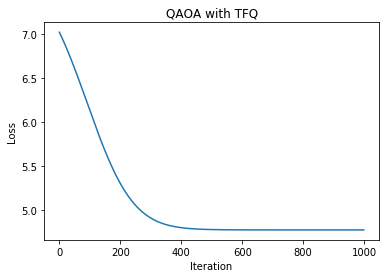

In [0]:
plt.plot(history.history['loss'])
plt.title("QAOA with TFQ")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [0]:
# Read out the optimal paramters and sample from the final state 1000 times
params = model.trainable_variables
add = tfq.layers.AddCircuit()
output_circuit = add(input_, append =qaoa_circuit )

sample_layer = tfq.layers.Sample()
output = sample_layer(output_circuit,  symbol_names=qaoa_parameters, symbol_values = params,repetitions=1000)

In [0]:
# Translate output in cut sets
cuts_qaoa = []
for bit_string in output.values:
  temp = []
  for pos, bit in enumerate(bit_string):
    if bit==1:
      temp.append(pos)
  cuts_qaoa.append(temp)

In [0]:
# Generate a list with all possible subsets
from itertools import combinations
sub_lists = []
for i in range(0, len(maxcut_graph.nodes())+1):
  temp = [list(x) for x in combinations(maxcut_graph.nodes(), i)]
  sub_lists.extend(temp)

In [0]:
# Calculate the cut_size for all possible cuts
cut_size = []
for sub_list in sub_lists:
  cut_size.append(nx.algorithms.cuts.cut_size(maxcut_graph,sub_list))

# Calculate the cut_size for the cuts found with QAOA
cut_size_qaoa = []
for cut in cuts_qaoa:
  cut_size_qaoa.append(nx.algorithms.cuts.cut_size(maxcut_graph,cut))

In [0]:
# Calculate the approximation ratio
np.mean(cut_size_qaoa)/np.max(cut_size)

0.7868461538461538